# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

# Part 0 Initialization

## 0.0 Import necessary module

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
# Import necessary modules
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

In [3]:
import os
import cv2 as cv2
import matplotlib.mlab
from collections import defaultdict
from functools import reduce

from skimage import measure
from scipy.optimize import curve_fit
from scipy.signal import medfilt
from scipy.stats import norm

In [97]:
tmp = img_dict['train'][4]

In [84]:
tmp_labels = gt_dict['train'][4]
tmp_labels = [item['bbox'] for item in tmp_labels]

In [65]:
416 * 5

2080

In [100]:
tmp.shape

(1906, 1694, 3)

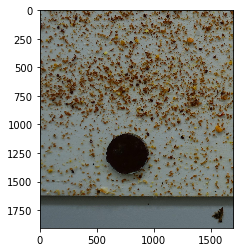

In [101]:
plt.imshow(tmp)

In [102]:
result = cv2.copyMakeBorder(tmp, 0, 2080 - tmp.shape[0], 0, 2080 - tmp.shape[1], cv2.BORDER_CONSTANT, 0)

In [104]:
result = cv2.resize(result, (416, 416))

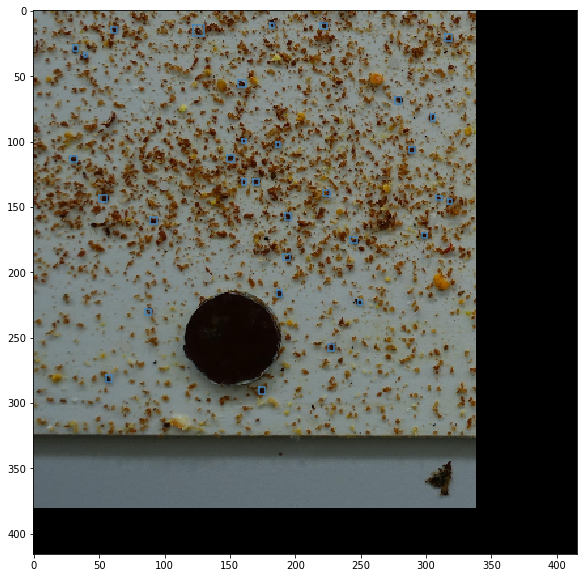

In [105]:
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(111)


ax.imshow(result)

for window in tmp_labels:
    
    plot_window(np.asarray(window) // 5, ax = ax)

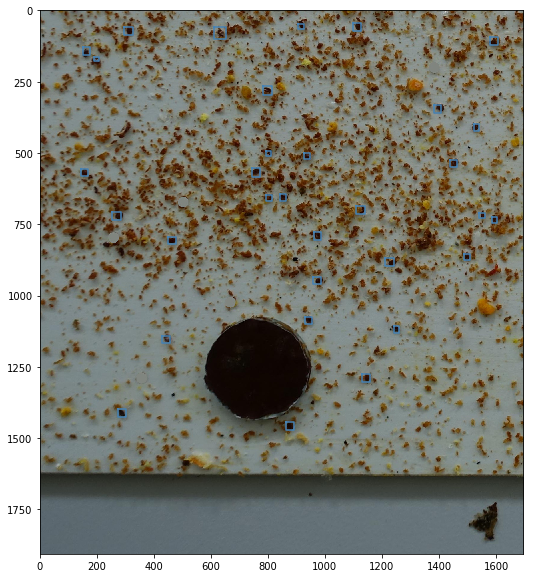

In [92]:
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(111)


ax.imshow(tmp)

for window in tmp_labels:
    
    plot_window(window , ax = ax)

In [200]:
result.shape

(100, 100, 3)

In [4]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

## 0.2 Load data

In [6]:
import pandas as pd

In [33]:
# Load images 
os.listdir('../data/project-data/')
data_dir = '../data/project-data/'

img_dict = dict()
gt_dict = dict()
img_types = ['train', 'validation', 'test']

for img_type in img_types:
    
    # Get file names
    with open(f'{data_dir}/{img_type}.txt', 'r') as f:
        
        filenames = f.read().split('\n')
        
    # Get images
    img_dict[img_type] = skimage.io.imread_collection([f'{data_dir}/images/{img_type}/{img_name}.jpg'
                                                      for img_name in filenames])
    
    # Get groundtruth
    gt_dict[img_type] = [parse_file(f'{data_dir}/annotations/{img_type}/{img_name}.xml')
                        for img_name in filenames]
    

In [103]:
# Convert the img to YOLO formats
import os

### Convert img to YOLO img

In [27]:
# Define target width and height
TARGET_WIDTH, TARGET_HEIGHT = 2080, 2080


target_dir = '/home/liangwei/work/ComputerScience/ComputerVision/keras-yolo2/data/validation/'

for i in range(len(img_dict['validation'])):
    
    print(f'Processing {i}th image')
    # Get img
    img = img_dict['validation'][i]
    
    # Get groundtruth
    gt = gt_dict['validation'][i]
    gt = [item['bbox'] for item in gt]

    # Calculate offset
    offset_y = TARGET_HEIGHT - img.shape[0]
    offset_x = TARGET_WIDTH - img.shape[1]

    # Create expanded img
    expanded_img = cv2.copyMakeBorder(img, 0, offset_y, 0, offset_x, cv2.BORDER_CONSTANT, 0)

    # Create shrink img
    shrink_img = cv2.resize(expanded_img, (416, 416))
    
    # Create annotation on expanded img
    locations_df = pd.DataFrame(data = gt, columns = ['x', 'y', 'width', 'height'])

    # Convert top x, y to center
    locations_df['x'] = locations_df['x'] + locations_df['width'] // 2
    
    locations_df['y'] = locations_df['y'] + locations_df['height'] // 2
    
    # Normalize
    locations_df /= 2080

    # Add class labels
    locations_df['class'] = 0
    
    # Write annotation to labels dir
    locations_df.to_csv(f'{target_dir}/labels/{i}.txt', sep = ' ',
                        columns = ['class', 'x', 'y', 'width', 'height'],
                        index = False,
                        header = None)
    
    # Write expanded img to images dir
    skimage.io.imsave(f'{target_dir}/images/{i}.jpg', shrink_img)

### Convert img to U-net img

In [57]:
count = 0 
for gt in gt_dict['train']:
    
    count += len(gt)

In [95]:
# Define target width and height
TARGET_WIDTH, TARGET_HEIGHT = 2048, 2048

# Define output width and height
OUTPUT_WIDTH, OUTPUT_HEIGHT = 512, 512

# Define type of data to be considered
TYPE = 'train'
target_dir = f'/home/liangwei/work/ComputerScience/ComputerVision/keras-yolo2/data/{TYPE}/'

for i in range(len(img_dict[TYPE][: 5])):
    
    print(f'Processing {i}th image')
    # Get img
    img = img_dict[TYPE][i]
    
    # Get groundtruth
    gt = gt_dict[TYPE][i]
    gt = [item['bbox'] for item in gt]

    print(f'Number of windows is {len(gt)}')
    # Calculate offset
    offset_y = TARGET_HEIGHT - img.shape[0]
    offset_x = TARGET_WIDTH - img.shape[1]

    # Create expanded img
    expanded_img = cv2.copyMakeBorder(img, 0, offset_y, 0, offset_x, cv2.BORDER_CONSTANT, 0)

    # Create shrink img
    shrink_img = cv2.resize(expanded_img, (OUTPUT_HEIGHT, OUTPUT_WIDTH))
    
    # Create mask
    mask = np.zeros((TARGET_HEIGHT, TARGET_WIDTH))
    
    # Populate mask
    for window in gt:
        
        mask[window[1] : window[1] + window[3], window[0] : window[0] + window[2]] = 1
    
    # Resize mask
    mask = cv2.resize(mask, (OUTPUT_HEIGHT, OUTPUT_WIDTH))

    mask = np.asarray(mask > 0).astype(np.uint8) 
    
    # Write to output folder 
    skimage.io.imsave(f'../data/unet_input/{TYPE}/images/{i}.jpg', shrink_img)
    
    skimage.io.imsave(f'../data/unet_input/{TYPE}/labels/{i}.jpg', mask * 255)

Processing 0th image
Number of windows is 0
Processing 1th image
Number of windows is 26
Processing 2th image
Number of windows is 3
Processing 3th image
Number of windows is 0
Processing 4th image
Number of windows is 32


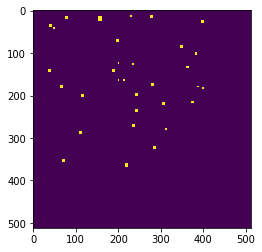

In [94]:
plt.imshow(mask)

In [76]:
np.unique(mask > 0, return_counts  = True)

(array([False,  True]), array([261891,    253]))

In [50]:
os.getcwd()

'/home/liangwei/work/ComputerScience/Image-Analysis-and-Pattern-Recognition/project'

In [46]:

img = img_dict['validation'][i]

# Get groundtruth
gt = gt_dict['validation'][i]
gt = [item['bbox'] for item in gt]

# Calculate offset
offset_y = TARGET_HEIGHT - img.shape[0]
offset_x = TARGET_WIDTH - img.shape[1]

# Create expanded img
expanded_img = cv2.copyMakeBorder(img, 0, offset_y, 0, offset_x, cv2.BORDER_CONSTANT, 0)

# Create shrink img
shrink_img = cv2.resize(expanded_img, (OUTPUT_HEIGHT, OUTPUT_WIDTH))

# Create mask
mask = np.zeros((TARGET_HEIGHT, TARGET_WIDTH))

# Populate mask
for window in gt:

    mask[window[1] : window[1] + window[3], window[0] : window[0] + window[2]] = 1

# Resize mask
mask = cv2.resize(mask, (OUTPUT_HEIGHT, OUTPUT_WIDTH))


In [47]:
len(gt)

0

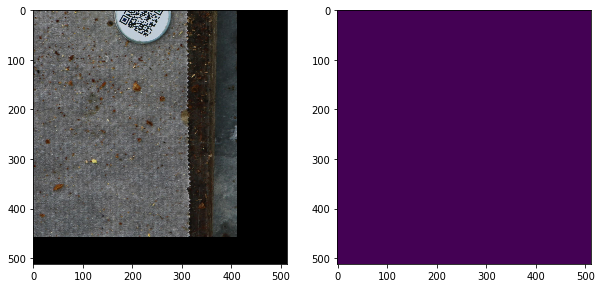

In [48]:
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(121)

ax.imshow(shrink_img)

ax = fig.add_subplot(122)
ax.imshow(mask)

In [112]:
data = pd.DataFrame(gt, columns = ['x', 'y', 'width', 'height'])

In [113]:
data.head()

,x,y,width,height
0,173,1310,25,24
1,85,867,22,26
2,656,1090,22,26
3,322,1346,25,24
4,1,759,23,28


In [114]:
data['x'] = data['x'] + data['width'] // 2
data['y'] = data['y'] + data['height'] // 2

In [116]:
data / 2080

,x,y,width,height
0,0.088942,0.635577,0.012019,0.011538
1,0.046154,0.423077,0.010577,0.012500
2,0.320673,0.530288,0.010577,0.012500
3,0.160577,0.652885,0.012019,0.011538
4,0.005769,0.371635,0.011058,0.013462
5,0.006731,0.490865,0.011538,0.011058
6,0.061058,0.491346,0.012019,0.012019
7,0.207692,0.698077,0.012019,0.012019
8,0.037019,0.491827,0.011538,0.011058
9,0.230769,0.677885,0.012019,0.011538


In [173]:
tmp_img = skimage.io.imread(target_dir + '/images/20.jpg')

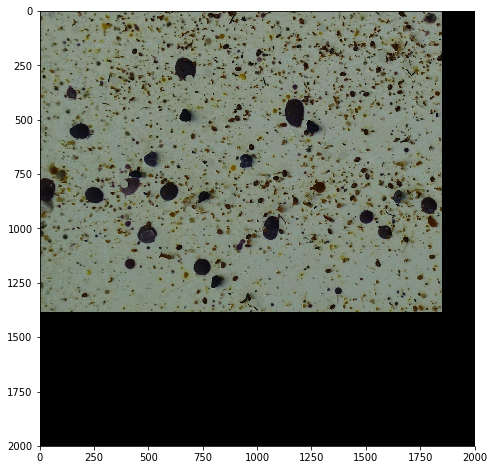

In [174]:
plt.imshow(tmp_img)

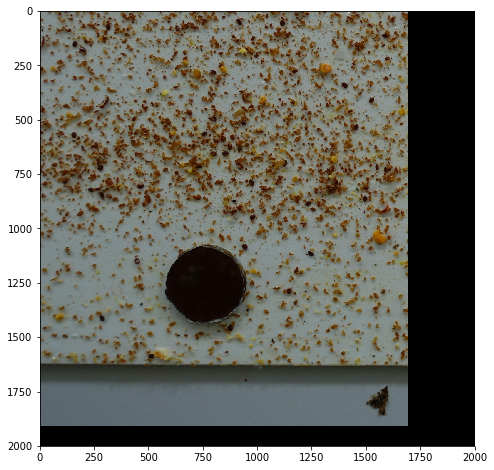

In [148]:
plt.imshow(expanded_img)

In [190]:
shapes = [img.shape for img in img_dict['validation']]

In [191]:
np.max(shapes, axis = 0)

array([1969, 1992,    3])

In [101]:
shapes = [img.shape for img in img_dict['test']]

In [102]:
np.max(shapes, axis = 0)

array([1985, 1985,    3])

# 1. Thresholding

In [8]:
# Get histogram of pixel values
k = 11
gray_img = skimage.color.rgb2gray(img_dict['train'][k]) * 256

## 1.1 Preprocess by smoothing

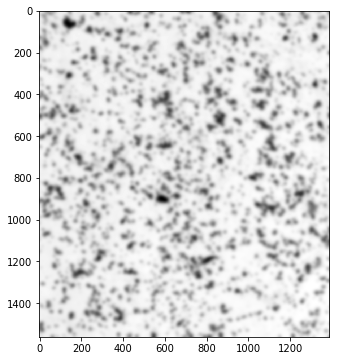

In [9]:
from scipy.signal import wiener

from scipy.ndimage.filters import gaussian_filter

tmp_median_smoothed = gaussian_filter(gray_img, 8)

fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
ax.imshow(tmp_median_smoothed, cmap = 'gray')

Unclear whether smoothing is useful. Need more investigation.

## 1.2 Find threshold to separate foreground and background

1. Gaussian fitting
  Fit gaussian to the gray level histogram and find the intersection of two gaussian as separating threshold.

2. Heuristic method
  Decide the threshold based on heuristics. 

In [10]:
def gauss(x, mean, sigma, A):
    
    return A * np.exp(-1 * (x - mean) ** 2 / (2 * sigma ** 2))

def bimodal(x, mean_f, sigma_f, A_f, mean_b, sigma_b, A_b):
    
    return gauss(x, mean_f, sigma_f, A_f) + gauss(x, mean_b, sigma_b, A_b)

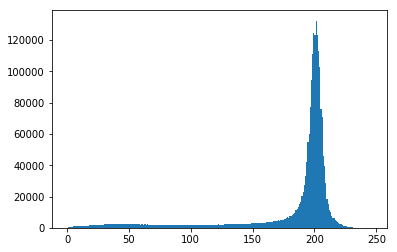

In [10]:
# Get count of pixels for each bins of gray values
counts, bins, _ = plt.hist(gray_img.ravel(), bins = 256)

In [11]:
# Initialize fore/back ground separation boundary
thrs_estimated = 100

In [12]:
# Fit gaussian to the white part
white_params, _ = curve_fit(gauss, np.arange(256 - thrs_estimated), counts[thrs_estimated: ])

# Fit gaussian to black part
black_params, _ = curve_fit(gauss, np.arange(thrs_estimated), counts[: thrs_estimated])

Text(0.5, 1.0, 'Black')

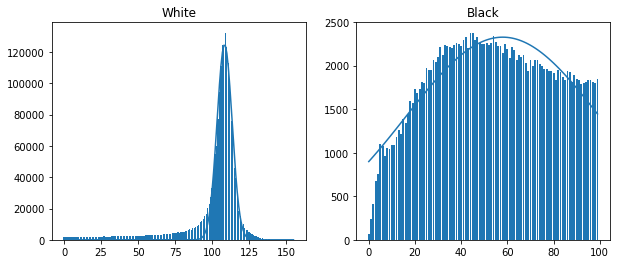

In [13]:
# Visualize the gaussian fit
fig = plt.figure(figsize = (10, 4))

# Plot white part
ax = fig.add_subplot(121)
ax.bar(np.arange(256 - thrs_estimated), counts[thrs_estimated:])
ax.plot(np.arange(256 - thrs_estimated), gauss(np.arange(256 - thrs_estimated), *white_params))
ax.set_title('White')

# Plot black part
ax = fig.add_subplot(122)
ax.bar(np.arange(thrs_estimated), counts[: thrs_estimated])
ax.plot(np.arange(thrs_estimated), gauss(np.arange(thrs_estimated), *black_params))
ax.set_title('Black')

In [11]:
# Find the threshold minimizing classification into foreground and background
def find_gaussian_intersection(mean_1, sigma_1, A_1, mean_2, sigma_2, A_2):
    """
    Find value where two gaussian have same probability
    Params: mean_1: mean of first gaussian
            sigma_1: std of first gaussian
            A_1: amplitude of first gaussian
            mean_2: mean of second gaussian
            sigma_2: std of second gaussian
            A_2: amplitude of second gaussian
    Return: intersection value
    """
    
    # Reduce the problem of solving a quadratic equation
    
    # Find second order param
    sec_param = (1 / (2 * sigma_2 ** 2) - 1 / (2 * sigma_1 ** 2))

    # Find first order param
    first_param = mean_1 / sigma_1 ** 2 - mean_2 / sigma_2 ** 2

    # Find constant param
    constant_param = mean_2 ** 2 / (2 * sigma_2 ** 2) - mean_1 ** 2 / (2 * sigma_1 ** 2) + \
                        np.log(A_1) - np.log(A_2)
    
    return np.roots([sec_param, first_param, constant_param])[1]

In [15]:
# Get threshold of foreground and background
thrs = find_gaussian_intersection(*white_params, *black_params)

In [16]:
print(f'Gaussian fitting results in separation threshold of {thrs}')

Gaussian fitting results in separation threshold of 93.42003788381324


In [17]:
# Map the image to binary img using threshold
bi_img = gray_img < thrs

Text(0.5, 1.0, 'Filtered by heuristic')

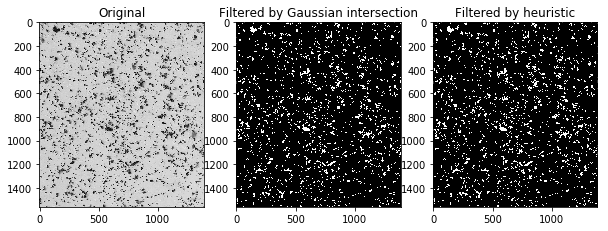

In [18]:
# Test the effect of thrs obtained from gaussian intersection
fig = plt.figure(figsize = (10, 4))
ax_list = fig.subplots(1, 3)

ax_list[0].imshow(gray_img, cmap = 'gray')
ax_list[1].imshow(bi_img, cmap = 'gray')
ax_list[2].imshow(gray_img < 100, cmap = 'gray')

ax_list[0].set_title('Original')
ax_list[1].set_title('Filtered by Gaussian intersection')
ax_list[2].set_title('Filtered by heuristic')

It is unclear whether Gaussian will outperform by heuristics as shown in the above comparisons.

For simplicity we continue with heuristics threshold.

In [12]:
# Set heuristic threshold
thrs = 100

# Get binary image by heuristic threshold
bi_img = gray_img < thrs

## 1.2 Label objects

1.2.1 Label objects using measure.label method provided in skimage module

1.2.2 Get features of detected objs including size and bounding rectangle

### 1.2.1 Conduct primitive labeling

In [13]:
# Get labels
labels = measure.label(bi_img)

In [14]:
# Illustrate labels
print(f'number of objects found are {np.max(labels) + 1}')

number of objects found are 2435


The above count show that primitive labeling cannot distinguish vorroa objs from the others since we only have tens of vorroas in an image generally.

### 1.2.2 Get size and bounding rectangle of each object

In [15]:
# Get size of detected objs
obj_sizes = dict(zip(*np.unique(labels, return_counts = True)))

# Build list of pixels for each obj
obj_pixels_alt = defaultdict(list)

for i in range(labels.shape[0]):
    
    for j in range(labels.shape[1]):
        
        obj_pixels_alt[labels[i][j]].append((i, j))

# Compute the covering rect of detected objs
obj_bbox = {k : np.asarray(cv2.boundingRect(np.asarray(obj_pixels_alt[k])))[[1, 0, 3, 2]]
            for k, v in obj_pixels_alt.items()}

# Get the area of bounding rectangle for each detected obj
obj_bbox_size = {k : obj_bbox[k][2] * obj_bbox[k][3] for k in obj_bbox.keys()}

Text(0.5, 1.0, 'Log-Log histogram of size of detected objs')

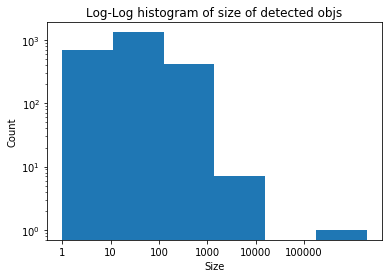

In [16]:
# Visualize the size distribution of objects
plt.hist(np.log10(list(obj_sizes.values())),
          bins = 6,
        log = True)
_ = plt.xticks(np.arange(6), [f'{10 ** s}' for s in np.arange(6)])
plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Log-Log histogram of size of detected objs')

From the distribution of size one can observe that there are two types of objs detected that should not be regarded as vorroas:

1. objects with extreme large size: these objects may be background or some unrelated objects

2. objects with extreme small size: these objects may be measurement noise

The above findings motivate us to find the thresholds for filtering objects by size.

## 1.3 Filter objects by size

1. Set thresholds by checking the distribution of vorroa's sizes in training data
2. Filter objects that are likely to be vorroa using aforementioned thresholds

### 1.3.1 Find distribution of size of vorroa

In [17]:
# Check avg vorroa size
avg_size_list = []

for i, img in enumerate(np.random.choice(gt_dict['train'], size = 500, replace = False)):
    
    # Add avg of vorroa size in this img to list
    try:
        
        avg_size_list += reduce(lambda l, item: l + [item['bbox'][2] * item['bbox'][3]],
                                   img,
                                    [])
    
    except:
        
        pass

In [18]:
# Get mean and var of size of vorroa obj
size_mean = np.mean(avg_size_list)

size_std = np.std(avg_size_list)

Text(0.5, 1.0, 'Groundtruth vorroa size distribution')

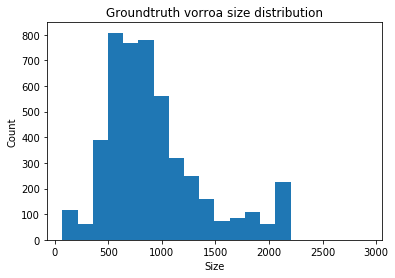

In [19]:
# Visualize the vorroa size distribution
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(avg_size_list, bins = 20)
ax.set_xlabel('Size')
ax.set_ylabel('Count')
ax.set_title('Groundtruth vorroa size distribution')

Assume that vorroa are located pairwisely independent,
Chebshev inequility indicates that by taking the size thrs to be $\mu + 3\sigma$,
we can capture about $90\%$ of vorroa objects.

So we may set the upper bound of size of an valid vorroa obj to be that value.

In [20]:
# Set upper size threshold
up_size_thrs = size_mean + 3 * size_std

By heuristics we may set the lower bound of size of an valid vorroa to be 350.

In [21]:
# Set lower size threshold
low_size_thrs = np.float64(350)

### 1.3.2 Filter detected obj based on size thresholds found.

In [22]:
# Filter the detected obj by size_thrs
obj_mask = np.where((list(obj_sizes.values()) > low_size_thrs) *\
                    (list(obj_sizes.values()) < up_size_thrs),
                    1,
                    0)

In [23]:
# Get the filtered objs
obj_bbox_values = list(obj_bbox.values())
filtered_objs = np.asarray([obj_bbox_values[i] for i in range(len(obj_mask)) if obj_mask[i]])

Text(0.5, 1.0, 'Groundtruth: Red   Detected: Steelblue')

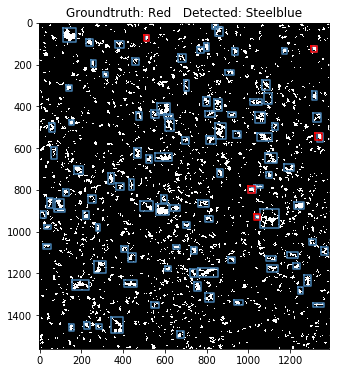

In [27]:
# Visualize the filtered objs on the binary figure
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)

# Show img
ax.imshow(bi_img, cmap = 'gray')

# Show detected objs
for obj in filtered_objs:
    
    ax.plot([obj[0], obj[0] + obj[2], obj[0] + obj[2], obj[0], obj[0]],
           [obj[1], obj[1], obj[1] + obj[3], obj[1] + obj[3], obj[1]],
           c = 'steelblue')

# Show ground truth obj
gt_objs = [item['bbox'] for item in gt_dict['train'][k]]

for obj in gt_objs:
    
    ax.plot([obj[0], obj[0] + obj[2], obj[0] + obj[2], obj[0], obj[0]],
       [obj[1], obj[1], obj[1] + obj[3], obj[1] + obj[3], obj[1]],
       c = 'red')

ax.set_title('Groundtruth: Red   Detected: Steelblue')

The results is still pretty noisy.
By observation we found out that there is possibility to filter based on density of the detected objects.

$density(obj) = \frac{\# pixels\ with\ value\ 1}{size\ of\ window}$

In [17]:
def plot_window(window, ax = None, c = None, label = None):
    """
    Plot the window
    Params: window: coordinates and length of the window
            ax: axes to plot 
            c: color
            label: label
    Return: 
    """
    
    if c == None:
        
        c = 'steelblue'
        
    if label == None:
        
        label = ''
        
    if ax != None:
        
        # Handle the case where axes to plot specified
        ax.plot([window[0], window[0] + window[2], window[0] + window[2], window[0], window[0]],
               [window[1], window[1], window[1] + window[3], window[1] + window[3], window[1]],
               c = c,
               label = label)
    
    else:
        
        # Handle the case where axes to plot not specified
        plt.plot([window[0], window[0] + window[2], window[0] + window[2], window[0], window[0]],
               [window[1], window[1], window[1] + window[3], window[1] + window[3], window[1]],
               c = c,
               label = label)

In [49]:
# Get the density for each filtered_obj
# Notice that the first coordinate actually means x0, thus is on the 2nd dimension
density = list(map(lambda window: np.sum(bi_img[window[1] : window[1] + window[3],
                                               window[0] : window[0] + window[2]]) /\
                                   (window[2] * window[3]),
                  filtered_objs))

(array([ 1.,  4.,  6., 29., 27., 16.,  8.,  8.,  2.,  4.]),
 array([0.18792517, 0.2430457 , 0.29816622, 0.35328675, 0.40840728,
        0.4635278 , 0.51864833, 0.57376886, 0.62888938, 0.68400991,
        0.73913043]),
 <a list of 10 Patch objects>)

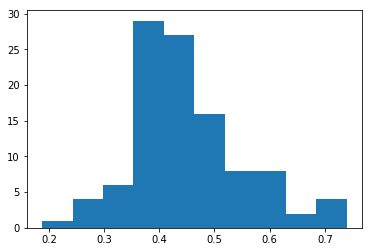

In [51]:
plt.hist(density, bins = 10)

In [53]:
# Obtain groundtruth density
gt_density = []

[[999, 782, 33, 33],
 [499, 61, 25, 27],
 [1025, 913, 30, 31],
 [1301, 113, 27, 29],
 [1320, 529, 30, 30]]

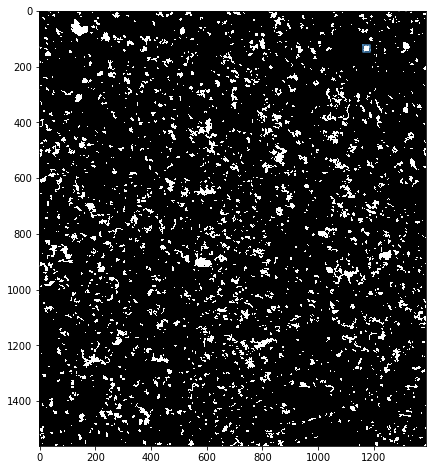

In [52]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
ax.imshow(bi_img, cmap = 'gray')
window = filtered_objs[9]
plot_window(window, ax = ax)

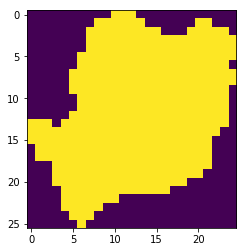

In [47]:
plt.imshow(bi_img[window[1] : window[1] + window[3],
                 window[0] : window[0] + window[2]])

In [45]:
window[0]

1161

## 1.4 Evaluation

Evaluate our segmentation results by calculating precision, recall and f1 score.

In [18]:
def calculate_IoU(a, b):
    """
    Calculate the IoU of a and b
    Params: a: (a.x, a.y, a.w, a.h)
            b: (b.x, b.y, b.w, b.h)
    Return: IoU(a, b)
    """
    
    # Calculate intersection area
    dx = min(a[0] + a[2], b[0] + b[2]) - max(a[0], b[0])
    dy = min(a[1] + a[3], b[1] + b[3]) - max(a[1], b[1])
    
    # Return zero if no intersection
    if dx <= 0 or dy <= 0:
        return 0
    
    # Set intersection area
    int_area = dx * dy
    
    # Calculate union length
    uni_area = a[2] * a[3] + b[2] * b[3] - int_area
    
    return int_area / uni_area 

In [19]:
def cal_stats(values, thrs, gtl):
    """
    Calculate precision, recall and f1_score for given thrshold
    Param: values : np.array
           thrs : double
           gtl : length of ground truth
    Return: (prec, recall, f1_score)
    """
    
    # Get boolean judgment for values using thrs
    results = np.asarray(values) > thrs
    
    # Get prec
    prec = np.sum(results) / len(values)
    
    # Get rec
    rec = np.sum(results) / gtl
    
    # Get f1_score
    f1 = 2 * prec * rec / (prec + rec)
    
    return (prec, rec, f1)

In [191]:
# Get the max IoU score for each filtered detected obj
iou_scores = [np.max([calculate_IoU(detected, gt) for gt in gt_objs]) for detected in filtered_objs]

In [192]:
# Get statistics for current img
prec, rec, f1 = cal_stats(iou_scores, thrs = 0.3, gtl = len(gt_objs))

In [193]:
print(f'Precision: {prec}\nRecall: {rec}\nF1: {f1}')

Precision: 0.0625
Recall: 1.0
F1: 0.11764705882352941


## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [59]:
THRS = 100
UP_SIZE_THRS = np.float64(2164.0)
LOW_SIZE_THRS = np.float64(350.0)

In [7]:
def detect_by_segmentation(img, thrs = THRS, up_size_thrs = UP_SIZE_THRS, low_size_thrs = LOW_SIZE_THRS):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    ''' Separate foreground and background '''
    
    # Convert img to gray scale
    gray_img = gray_img = skimage.color.rgb2gray(img) * 256
    
    # Filter img
    bi_img = gray_img < thrs
    

    ''' Label objects '''
    # Get labels
    labels = measure.label(bi_img)

    # Get size of detected objs
    obj_sizes = dict(zip(*np.unique(labels, return_counts = True)))
    
    # Formulate obj as list of pixels
    obj_pixels = defaultdict(list)

    for i in range(labels.shape[0]):

        for j in range(labels.shape[1]):

            obj_pixels[labels[i][j]].append((i, j))
            

    ''' Filter objs based on size'''
    # Compute the bounding rect of detected objs
    obj_bbox = {k : np.asarray(cv2.boundingRect(np.asarray(obj_pixels[k])))[[1, 0, 3, 2]]
                for k, v in obj_pixels.items()}

    # Filter the detected obj by size_thrs
    obj_mask = np.where((list(obj_sizes.values()) > low_size_thrs) *\
                        (list(obj_sizes.values()) < up_size_thrs),
                        1,
                        0)

    # Get the filtered objs
    obj_bbox_values = list(obj_bbox.values())
    filtered_objs = np.asarray([obj_bbox_values[i] for i in range(len(obj_mask)) if obj_mask[i]])
    
    return filtered_objs

NameError: name 'THRS' is not defined

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [76]:
# Get test imgs
test_imgs = img_dict['test']

# Get test groundtruth
test_gt = gt_dict['test']

# Get number of ground truth objs
gtl = reduce(lambda current_length, next_item: current_length + len(next_item), test_gt, 0)

# Initialize iou_scores
iou_scores_all = []

# Loop through all img to detect vorroas
for i, img in enumerate(test_imgs):
    
    # Get detected objs
    detected_objs = detect_by_segmentation(img)
    
    # Get groundtruth
    gt_img = [item['bbox'] for item in test_gt[i]]
    
    # Compute max IoU score for each detected obj
    iou_scores = [np.max([calculate_IoU(detected, gt) for gt in gt_img]) if len(gt_img) > 0 else 0 \
                  for detected in detected_objs]
    
    # Append results for this img to total results
    iou_scores_all += iou_scores

# Calculating statistics
prec, rec, f1 = cal_stats(iou_scores_all, thrs = 0.3, gtl = gtl)

In [80]:
print(f'Precision: {prec}\nRecall: {rec}\nF1: {f1}')

Precision: 0.09903121636167922
Recall: 0.4742268041237113
F1: 0.163846838824577


## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

## 2.1 Prepare data

From the vorroa size distribution, one may convince himself that setting the sliding window with length 48 and width 48 sufficies to detect all feasible vorroas.

The step of window cropping scheme results in the low recall of adaptive crop labeling algorithm.

Now let's try on manually building positive windows.

The histogram illustrates that window size of 48 * 48 captures the majority of vorroas

Now let's boost each groundtruth window to size of 48 * 48


In [7]:
window_height, window_width = 32, 32

In [8]:
def expand_window(img, gt_windows, window_width = window_width, window_height = window_height):
    """
    Expand window of img to (window_width, window_height)
    Params: img: (n, m, 3) array
            gt_windows: list of windows
            window_width: width
            window_height: height
    Return: list of expanded windows
    """

    # Get height and width of img
    height, width, _ = img.shape
    results = []
    
    for window in gt_windows:

        # Get x dimension increment to make
        delta_x = window_width - window[2]

        # Get y dimension increment to make
        delta_y = window_height - window[3]

        if window[0] < (delta_x // 2):
            # Handle the case where left space is not enough

            x_new = 0

        elif window[0] + window[2] + (delta_x - delta_x // 2) >= width:
            # Handle the case where right space is not enough

            x_new = width - 1 - window_width

        else:
            # Handle normal case

            x_new = window[0] - delta_x // 2

        if window[1] < (delta_y // 2):
            # Handle the case where upper space is not enough

            y_new = 0

        elif window[1] + window[3] + (delta_y - delta_y // 2) >= height:
            # Handle the case where lower space is not enough

            y_new = height - 1 - window_width

        else:

            y_new = window[1] - delta_y // 2

        results.append([x_new, y_new, window_width, window_height])
    
    return results

In [20]:
def construct_training_crops(img, windows, 
                             window_width = window_width,
                             window_height = window_height,
                             negative_increment = 5):
    """
    Construct training crops from img with specific window height and width
    Return: [positive_crops, negative_crops]
    """
    
    """ Build positive samples by expanding the gt window to required shape """
    expanded_windows = expand_window(img, windows)

    vorroa_crops = [img[window[1] : window[1] + window[3], window[0] : window[0] + window[2]] \
                   for window in expanded_windows]

    """ Build negative samples by random sampling """

    # Define sample size for each img
    negative_sample_size = len(vorroa_crops) + negative_increment

    # Sample starting point
    negative_x = np.random.choice(img.shape[1] - window_width, negative_sample_size)
    negative_y = np.random.choice(img.shape[0] - window_height, negative_sample_size)

    # Construct windows
    negative_windows = list(zip(negative_x,\
                                negative_y,\
                                np.ones(len(negative_x)).astype(np.int) * window_width,\
                                np.ones(len(negative_x)).astype(np.int) * window_height))

    # Filter windows overlapping vorroa windows
    if len(vorroa_crops) > 0:
        
        negative_windows = list(filter(lambda window: np.max([calculate_IoU(window, gt_window)\
                                           for gt_window in expanded_windows]) < 0.3,
                   negative_windows))

    # Get the content of negative window
    negative_crops = [img[window[1] : window[1] + window[3], window[0] : window[0] + window[2]] \
                   for window in negative_windows]

    negative_crops = np.asarray(negative_crops)
    
    if len(vorroa_crops) == 0:
        
        return negative_crops, [0] * len(negative_crops)
    
    else:
        
        return np.concatenate([vorroa_crops, negative_crops]), np.concatenate([[1] * len(vorroa_crops),
                                                                          [0] * len(negative_crops)])

In [622]:
crops, labels = [], []

In [623]:
for i in range(len(gt_dict['train'])):
    
    # Get img
    img = img_dict['train'][i]
    
    # Get gt_windows
    gt_windows = gt_dict['train'][i]
    
    gt_windows = [item['bbox'] for item in gt_windows]
    
    # Get crops and labels
    current_crops, current_labels = construct_training_crops(img, gt_windows)
    
    # Update crops and labels
    try:
        
        crops = np.concatenate([crops, current_crops], axis = 0)
    
    except:
        
        crops = current_crops
    
    labels = np.concatenate([labels, current_labels])

In [34]:
# Store data to file
np.save('window_crops', crops)

np.save('labels', labels)

Please load them from local file directly once created.

In [21]:
window_crops = np.load('window_crops.npy')

labels = np.load('labels.npy')

## 2.2 Generate feature

In [10]:
def find_fourier_descriptor(img, l = 1):
    """
    Find the l-th fourier descriptor for given img
    Params: img: np.array
            l: int
    Return: (x, y)
    """

    # Get test img
    test_img = img

    # Convert gray img to binary img
    thrs = (test_img < 100) * 255
    thrs = thrs.astype(np.uint8)

    # Find contour
    contours, hier = cv2.findContours(thrs, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # Return origin if no contours were found
    if len(contours) == 0:
        
        return 0, 0
    
    # For simplicity we only take the longest contour
    contour = sorted(contours, key = lambda x: len(x))[-1]

    # Normalization
    contour = contour.reshape(-1, 2).T

    contour -= np.mean(contour, axis = 1).astype(np.int).reshape(2, 1)

    # Get length of contour
    N = len(contour[0])

    # Get real part of contour
    real = contour[0]

    # Get imaginary part of contour
    imginary = contour[1] * 1j

    # Build Fourier descriptor for the contour

    # First Fourier descriptor
    f = np.sum((real + imginary) * np.exp(-2 * np.pi * l * 1j / N * np.arange(N)))

    # Second Fourier descriptor
    # f2 = np.sum((real + imginary) * np.exp(2 * np.pi * 1j / N * np.arange(0, 2 * N, 2)))

    # Return real and imaginary part of f1
    return f.real, f.imag

In [11]:
def generate_features(img):
    """
    Generate feature vectors of |f1|, |f2|, avg and std of R, G, B colors from cropped img
    Params: img
    Return: features
    """
    
    # Convert img to gray scale
    gray_img = skimage.color.rgb2gray(img) * 255
    
    # Get first fourier descriptor
    f1_norm = np.sqrt(np.sum(np.square(find_fourier_descriptor(gray_img, 1))))
    
    # Get second fourier descriptor
    f2_norm = np.sqrt(np.sum(np.square(find_fourier_descriptor(gray_img, 2))))
    
    # Get avg and std of R, G, B channel
    avg = np.mean(img, axis = (0, 1))
    
    std = np.std(img, axis = (0, 1))

    return np.concatenate([[f1_norm, f2_norm], avg, std])

In [12]:
def generate_test_features(img, window_height = 32, window_width = 32, stride = 16):
    """
    Generate features and positions for a full test img
    Params: test img
    Return: list of features, list of bouding box
    """
    
    # Initialize features list and position list
    features = []
    positions = []
    
    # Loop through all boxes to generate features
    for x in range(0, img.shape[1] - window_width, stride):
        
        for y in range(0, img.shape[0] - window_height, stride):
            
            # Generate features for current crop
            feature = generate_features(img[y : y + window_height, x : x + window_width])
            
            # Add feature to features list
            features.append(feature)
            
            # Add bounding box to positions list
            positions.append([x, y, window_width, window_height])
            
    return features, positions

In [13]:
def get_false_positive(pred_positive_windows, gt_windows, img, thrs = 0.2):
    """
    Get false positive in training set for iterative training
    @Params: pred_positive_windows: windows that are predicted to be positives
             gt_windows: ground truth windows
             img: img generateing the results
             thrs: threshold for filtering false positive
    @Return: false_positive features, 
    """

    # Get predicted windows
    pred_windows = pred_positive_windows

    # Get false positive windows
    if len(gt_windows) != 0:
        false_positive_windows = pred_windows[[np.max([calculate_IoU(pred, gt)\
                                                       for gt in gt_windows]) < thrs\
                                               for pred in pred_windows]]
    else:
        false_positive_windows = pred_windows

    # Conduct non-max suppression 
    false_positive_windows = non_max_suppression_fast(false_positive_windows, 0.25)
    
    # Construct features for false positive
    false_positive_features = [generate_features(img[window[1] : window[1] + window[3],
                                                    window[0] : window[0] + window[2]])
                              for window in false_positive_windows]

    # Reshape feature
    false_positive_features = np.concatenate(false_positive_features).reshape(-1, 8)
    
    return false_positive_features

In [93]:
# Generate features for all training crops
x = np.asarray([generate_features(crop) for crop in window_crops])

## 2.3 Classification

### 2.3.1 Initial training of SVC

In [16]:
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score

In [97]:
# Build train test split

# Get shuffle permutation
indices = np.random.permutation(len(x))

# Get train and test indices 
train_indices = indices[: int(0.8 * len(indices))]

test_indices = indices[int(0.8 * len(indices)) :]

# Get train and test split
x_train = x[train_indices]

y_train = labels[train_indices]

x_test = x[test_indices]

y_test = labels[test_indices]

crops_test = window_crops[test_indices]

crops_train = window_crops[train_indices]

""" Normalize training and testing data"""

x_mean = np.mean(x_train, axis = 0)

x_std = np.std(x_train, axis = 0)

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

# Build classifier 
svc = SVC(probability = True)

# Train
svc.fit(x_train, y_train)

# Find training prediction
y_train_pred = svc.predict(x_train)

y_train_pred_proba = svc.predict_proba(x_train)

# Find testing prediction
y_test_pred_proba = svc.predict_proba(x_test)

y_test_pred = svc.predict(x_test)

In [98]:
print(f'Testing accuracy is {np.mean(y_test_pred == y_test)}')
print(f'Testing precision is {precision_score(y_test, y_test_pred)}')
print(f'Testing recall is {recall_score(y_test, y_test_pred)}')
print(f'Testing f1 score is {f1_score(y_test, y_test_pred)}')

Testing accuracy is 0.9453041622198506
Testing precision is 0.8968354430379747
Testing recall is 0.9712131596984236
Testing f1 score is 0.9325435998683778


In [630]:
print(f'Training accuracy is {np.mean(y_train_pred == y_train)}')
print(f'Training precision is {precision_score(y_train, y_train_pred)}')
print(f'Training recall is {recall_score(y_train, y_train_pred)}')
print(f'Training f1 score is {f1_score(y_train, y_train_pred)}')

Training accuracy is 0.9435521492835721
Training precision is 0.9041074496329845
Training recall is 0.9613085353703089
Training f1 score is 0.931830985915493


The testing results seems to be acceptable.

Now let's try it on full images.

In [158]:
# Get train img and label
results = []
for k in range(50):
    
    print(f'Processing {k}')
    # Get full img
    full_img = img_dict['train'][k]

    # Get full groundtruth
    full_gt = gt_dict['train'][k]
    full_gt = np.asarray([item['bbox'] for item in full_gt])
    
    # Generate features and positions for full img
    features, positions = generate_test_features(full_img, 32, 32, 16)
    positions = np.asarray(positions)

    # Normalize full features
    features = (features - x_mean) / x_std

    # Conduct classification on full crops
    y_test_pred = svc.predict(features)

    # Get predict positives windows
    pred_positives = np.where(y_test_pred == 1)[0]
    
    pred_positive_windows = np.asarray(positions[pred_positives])
    
    if len(pred_positives) == 0:
        
        continue
        
    # Get false positive features
    results.append(get_false_positive(pred_positive_windows, full_gt, full_img))

Processing 0
Processing 1
Processing 2
Processing 3
Processing 4
Processing 5
Processing 6
Processing 7
Processing 8
Processing 9
Processing 10
Processing 11
Processing 12
Processing 13
Processing 14
Processing 15
Processing 16
Processing 17
Processing 18
Processing 19
Processing 20
Processing 21
Processing 22
Processing 23
Processing 24
Processing 25
Processing 26
Processing 27
Processing 28
Processing 29
Processing 30
Processing 31
Processing 32
Processing 33
Processing 34
Processing 35
Processing 36
Processing 37
Processing 38
Processing 39
Processing 40
Processing 41
Processing 42
Processing 43
Processing 44
Processing 45
Processing 46
Processing 47
Processing 48
Processing 49


In [159]:
results = np.concatenate(results)

### 2.3.2 Iterative training

In [160]:
# Replace negative samples in training set by false positive 
positive_indices = np.where(labels == 1)[0]

x_updated = np.concatenate([x, results])
y_updated = np.asarray(list(labels) + [0] * len(results))

In [161]:
np.save('x_iterated_train', x_updated)
np.save('y_iterated_train', y_updated)

In [176]:
# Re-train

# Build train test split

# Get shuffle permutation
indices = np.random.permutation(len(x_updated))

# Get train and test indices 
train_indices = indices[: int(0.6 * len(indices))]

test_indices = indices[int(0.6 * len(indices)) :]

# Get train and test split
x_train = x_updated[train_indices]

y_train = y_updated[train_indices]

x_test = x_updated[test_indices]

y_test = y_updated[test_indices]

""" Normalize training and testing data"""

x_mean = np.mean(x_train, axis = 0)

x_std = np.std(x_train, axis = 0)

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

# Build classifier 
svc = SVC(probability = True, class_weight = 'balanced')

# Train
svc.fit(x_train, y_train)

# Find training prediction
y_train_pred = svc.predict(x_train)

y_train_pred_proba = svc.predict_proba(x_train)

# Find testing prediction
y_test_pred_proba = svc.predict_proba(x_test)

y_test_pred = svc.predict(x_test)

In [163]:
tmp_pred = svc.predict(x_train)

In [177]:
print(f'Training accuracy is {np.mean(y_train_pred == y_train)}')
print(f'Training precision is {precision_score(y_train, y_train_pred)}')
print(f'Training recall is {recall_score(y_train, y_train_pred)}')
print(f'Training f1 score is {f1_score(y_train, y_train_pred)}')

Training accuracy is 0.8480100846389339
Training precision is 0.6514044487741516
Training recall is 0.912440300204685
Training f1 score is 0.7601364153088291


### 2.3.3 Post processing

### 2.3.3.1 Recenter 

In this section we post process by recenter the detected region using center of mass.

Not clear whether it is useful.

In [18]:
from scipy.ndimage.measurements import center_of_mass

In [17]:
def recenter(img, windows, window_width = 32, window_height = 32):
    """
    Rencenter windows to centered at centroid of mass
    @Params: img: image where windows reside
             windows: list of windows
    @Return: recentered_windows
    """
    
    recentered_windows = []
    
    for window in windows:
        
        # Get crop
        crop = img[window[1] : window[1] + window[3],
                   window[0] : window[0] + window[2]]
        
        # Get center of mass
        delta_y, delta_x = center_of_mass(skimage.color.rgb2gray(crop) * 255 < 100)
        
        # Continue if no center of mass exists
        if np.isnan(delta_x) or np.isnan(delta_y):
            
            continue
            
        # Get recentered window
        recentered_window = [max(0, window[0] + int(delta_x) - window_width //2),
                            max(0, window[1] + int(delta_y) - window_height // 2),
                            window_width,
                            window_height]
        
        recentered_windows.append(recentered_window)
    
    return recentered_windows

In [19]:
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2] + x1
    y2 = boxes[:,3] + y1

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

## 2.4 Evaluations

### 2.4.1 Define classifier

In [20]:
# Load training data
x = np.load('x_iterated_train.npy')

y = np.load('y_iterated_train.npy')

In [21]:
x_mean = np.mean(x, axis = 0)

x_std = np.std(x, axis = 0)

In [22]:
# Preprocess 
x = (x - x_mean) / x_std

In [23]:
def detect_by_svc(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    # Get features and positions of crops of img
    features, positions = generate_test_features(img,
                                                 window_height = 32,
                                                 window_width = 32,
                                                stride = 16)
    positions = np.asarray(positions)
    
    # Normalizations
    features = (features - x_mean) / x_std
    
    # Get predictions
    predictions = svc.predict(features)
    
    # Get predicted positive windows
    pred_pos_windows = positions[np.where(predictions == 1)[0]]
    
    # Recenter the windows
    recentered_pos_windows = np.asarray(recenter(img, pred_pos_windows))

    # Non max suppression 
    filtered_pos_windows = non_max_suppression_fast(recentered_pos_windows, 0.1)
    
    return filtered_pos_windows

In [24]:
# Train
svc = SVC(probability = True)

svc.fit(x, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

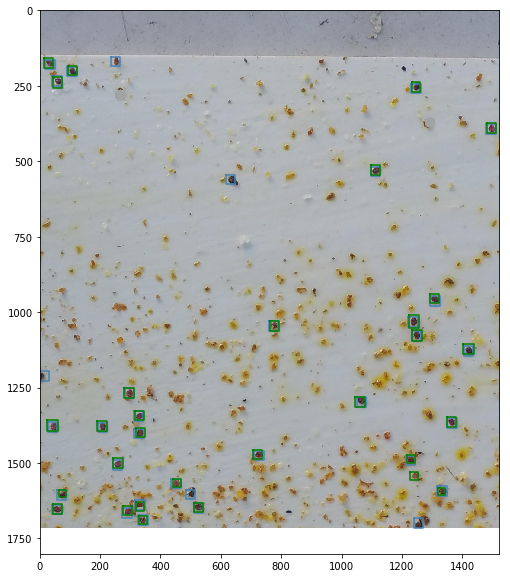

In [32]:
""" Illustrate the performance on some img """
k = 7
tmp_img = img_dict['test'][k]
tmp_gt = gt_dict['test'][k]
tmp_gt = [item['bbox'] for item in tmp_gt]

# Visualize 
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(111)

ax.imshow(img_dict['test'][k])

filtered_pos_windows = detect_by_svc(img_dict['test'][k])

# Compute max IoU score for each detected obj
iou_scores = [np.max([calculate_IoU(detected, gt) for gt in tmp_gt]) \
              if len(tmp_gt) > 0 else 0 \
              for detected in filtered_pos_windows]

for window in filtered_pos_windows:
    
    plot_window(window, ax = ax)

for window in tmp_gt:
    
    plot_window(window, ax = ax, c = 'green')
    
fig.savefig('recentered')

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [33]:
#Your code
# Get test imgs
test_imgs = img_dict['test']

# Get test groundtruth
test_gt = gt_dict['test']

# Get number of ground truth objs
gtl = reduce(lambda current_length, next_item: current_length + len(next_item), test_gt, 0)

# Initialize iou_scores
iou_scores_all = []

# Loop through all img to detect vorroas
for i, img in enumerate(test_imgs):
    
    print(f'Processing {i}th img')
    # Get detected windows
    detected_windows = detect_by_svc(img)
    
    # Get groundtruth
    gt_img = [item['bbox'] for item in test_gt[i]]
    
    # Compute max IoU score for each detected obj
    iou_scores = [np.max([calculate_IoU(detected, gt) for gt in gt_img]) if len(gt_img) > 0 else 0 \
                  for detected in detected_windows]
    
    # Append results for this img to total results
    iou_scores_all += iou_scores

# Calculating statistics
prec, rec, f1 = cal_stats(iou_scores_all, thrs = 0.3, gtl = gtl)

Processing 0th img
Processing 1th img
Processing 2th img
Processing 3th img
Processing 4th img
Processing 5th img
Processing 6th img
Processing 7th img
Processing 8th img
Processing 9th img
Processing 10th img
Processing 11th img
Processing 12th img
Processing 13th img
Processing 14th img
Processing 15th img
Processing 16th img
Processing 17th img
Processing 18th img
Processing 19th img
Processing 20th img
Processing 21th img
Processing 22th img
Processing 23th img
Processing 24th img
Processing 25th img
Processing 26th img
Processing 27th img
Processing 28th img
Processing 29th img
Processing 30th img
Processing 31th img
Processing 32th img
Processing 33th img
Processing 34th img
Processing 35th img
Processing 36th img
Processing 37th img
Processing 38th img
Processing 39th img
Processing 40th img
Processing 41th img
Processing 42th img
Processing 43th img
Processing 44th img
Processing 45th img
Processing 46th img
Processing 47th img
Processing 48th img
Processing 49th img


In [34]:
print(f'prec: {prec} \n rec: {rec}\n f1: {f1}')

prec: 0.1659021406727829 
 rec: 0.7457044673539519
 f1: 0.2714196372732958


## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

### 3.0 Initialization

In [15]:
# Import necessary modules
import keras

In [16]:
import keras_metrics

### 3.1 Build training and validation data

In [23]:
x, y = window_crops, labels

In [18]:
# Get train and test data
x_train, x_val, y_train, y_val = train_test_split(x, y)

In [10]:
# Get positive and negative indices
positive_indices = np.where(labels == 1)[0]

# To boost recall we only sample a subset of negative samples
negative_indices = np.where(labels == 0)[0][: len(positive_indices)]

# Get train and validation indices
train_indices = np.concatenate([positive_indices[: int(train_val_ratio * len(positive_indices))],
                               negative_indices[: int(train_val_ratio * len(negative_indices))]])

val_indices = np.concatenate([positive_indices[int(train_val_ratio * len(positive_indices)) :],
                               negative_indices[int(train_val_ratio * len(negative_indices)) :]])

# Build training data
x_train = window_crops[train_indices]

y_train = labels[train_indices]

# Build validation data
x_val = window_crops[val_indices]

y_val = labels[val_indices]

In [15]:
def preprocess(x, y = [], num_classes = 2):
    """
    Preprocess by normalizing x to [0, 1], y to (N, num_classes)
    Params: x: features
            y: labels
            num_classes
    Return: x_normalized, y_categorical
    """

    # Normalize training and validation data
    x = x.astype('float32')
    x /= 255
    
    if len(y) == 0:
        return x
    
    # Convert class vectors to binary class matrices
    y = keras.utils.to_categorical(y, num_classes)
    
    return x, y

In [19]:
# Preprocess
x_train, y_train = preprocess(x_train, y_train)
x_val, y_val = preprocess(x_val, y_val)

In [20]:
# Get input shape
input_shape = x_train.shape[1 : ]

### 3.2 Build and train classifier

In [14]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


Using TensorFlow backend.


In [22]:
# Define hyperparameters
batch_size = 128
num_classes =  2
epochs = 12

In [23]:
model = Sequential()

# Add first convolution layer
model.add(Conv2D(filters = 32,
                 kernel_size = (3, 3),
                activation = 'relu', 
                input_shape = input_shape))

# Add second convlution layer
model.add(Conv2D(filters = 64,
                 kernel_size = (3, 3),
                activation = 'relu'))

# Add first max pooling layer
model.add(MaxPooling2D(pool_size = (2, 2)))

# Add first dropout layer
model.add(Dropout(0.25))

# Flatten 
model.add(Flatten())

# Add first dense layer
model.add(Dense(128, activation = 'relu'))

# Add 2nd dropout layer
model.add(Dropout(0.5))

# Add classification layer
model.add(Dense(num_classes,
                activation = 'softmax'))

In [26]:
# Define loss, optimization scheme
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adadelta(),
             metrics = [keras_metrics.precision(), keras_metrics.recall()])

In [27]:
# Train
model.fit(x_train, y_train,
         batch_size = batch_size,
         epochs = epochs,
         verbose = 1,
         validation_data = (x_val, y_val))

Train on 14054 samples, validate on 4685 samples
Epoch 1/12
14054/14054 [==============================] - 98s 7ms/step - loss: 0.2832 - precision: 0.9056 - recall: 0.9199 - val_loss: 0.1028 - val_precision: 0.9849 - val_recall: 0.9580
Epoch 2/12
14054/14054 [==============================] - 108s 8ms/step - loss: 0.1114 - precision: 0.9724 - recall: 0.9732 - val_loss: 0.1027 - val_precision: 0.9860 - val_recall: 0.9598
Epoch 3/12
  512/14054 [>.............................] - ETA: 1:36 - loss: 0.0947 - precision: 0.9653 - recall: 0.9745

KeyboardInterrupt: 

## 3.3 Evaluate on full image

In [87]:
def get_false_positive_crops(pred_positive_windows, gt_windows, img, thrs = 0.2):
    """
    Get false positive in training set for iterative training
    @Params: pred_positive_windows: windows that are predicted to be positives
             gt_windows: ground truth windows
             img: img generateing the results
             thrs: threshold for filtering false positive
    @Return: false_positive features, 
    """

    # Get predicted windows
    pred_windows = pred_positive_windows

    # Get window width and height
    window_width = pred_windows[2]
    
    window_height = pred_windows[3]
    
    # Get false positive windows
    if len(gt_windows) != 0:
        false_positive_windows = pred_windows[[np.max([calculate_IoU(pred, gt)\
                                                       for gt in gt_windows]) < thrs\
                                               for pred in pred_windows]]
    else:
        false_positive_windows = pred_windows

    # Conduct non-max suppression 
    false_positive_windows = non_max_suppression_fast(false_positive_windows, 0.25)
    
    # Obtain false positive crops
    false_positive_crops = np.asarray([img[window[1] : window[1] + window[3],
                                          window[0] : window[0] + window[2]] \
                                      for window in false_positive_windows])
    
    return false_positive_crops, false_positive_windows

In [88]:
crops, windows = get_false_positive_crops(filtered_windows, test_windows, test_img)

### 3.3 Evaluate classifier on test data

#### 3.3.1 Build test data

In [54]:
# Get x_test and y_test
test_crops, test_labels = [], []

for i in range(len(gt_dict['test'])):
    
    # Get img
    img = img_dict['test'][i]
    
    # Get gt_windows
    gt_windows = gt_dict['test'][i]
    
    gt_windows = [item['bbox'] for item in gt_windows]
    
    # Get crops and labels
    current_crops, current_labels = construct_training_crops(img, gt_windows, negative_increment = 20,
                                                            window_width = window_width,
                                                             window_height = window_height)
    
    # Update crops and labels
    try:
        
        test_crops = np.concatenate([test_crops, current_crops], axis = 0)
    
    except:
        
        test_crops = current_crops
    
    test_labels = np.concatenate([test_labels, current_labels])

In [55]:
len(test_labels)

2127

In [56]:
# Preprocess x_test and y_test
x_test, y_test = preprocess(test_crops, test_labels)

#### 3.3.2 Evaluate on test crops

In [60]:
# Evaluate on x_test and y_test
results = model.evaluate(x_test, y_test, verbose = 1)
print(f'The precision on test data is {results[1]}')
print(f'The recall on test data is {results[2]}')

2127/2127 [==============================] - 3s 2ms/step
The precision on test data is 0.9718670076104944
The recall on test data is 0.9838187701628596


#### 3.3.3 Evaluate on full test images

We loop through all candidate crops to find the candidate vorroa window

In [61]:
for i in [20]:
    
    # Get test img
    test_img = img_dict['train'][i]
    
    # Get test img's groundtruth windows
    test_windows = gt_dict['train'][i]
    test_windows = [item['bbox'] for item in test_windows]
    
    # Generate candidate windows
    candidate_windows = list(zip(*map(lambda x: x.ravel(),
                            np.meshgrid(np.arange(0, test_img.shape[1] - window_width + 1, window_width // 2),
                                          np.arange(0, test_img.shape[0] - window_height + 1, window_height // 2),
                                                  indexing = 'xy'))))
    
    # print(candidate_windows)
    candidate_windows = np.concatenate([candidate_windows,\
                                        np.ones((len(candidate_windows), 2)) * 48],\
                                       axis = 1).astype('int')
    
    # Build candidate crops
    candidate_crops = [test_img[window[1] : window[1] + window[3],
                               window[0] : window[0] + window[2]] for window in candidate_windows]
    shapes = [candidate.shape for candidate in candidate_crops]
    candidate_crops = np.concatenate(candidate_crops).reshape(-1, window_height, window_width, 3)
    
    """ Predict for candidate crops """
    
    # Normalize candidate crops
    normalized_candidate_crops = preprocess(candidate_crops)
    
    # Predict
    y_test_pred = model.predict_classes(normalized_candidate_crops)

In [62]:
# Get predicted windows 
pred_windows = candidate_windows[y_test_pred == 1]

# Get groundtruth windows
test_windows = gt_dict['train'][20]
test_windows = [item['bbox'] for item in test_windows]

In [67]:
pred_windows

array([[ 336,    0,   48,   48],
       [ 528,    0,   48,   48],
       [ 768,    0,   48,   48],
       ...,
       [ 936, 1296,   48,   48],
       [1584, 1296,   48,   48],
       [1608, 1320,   48,   48]])

In [69]:
len(pred_windows)

272

In [80]:
len(filtered_windows)

205

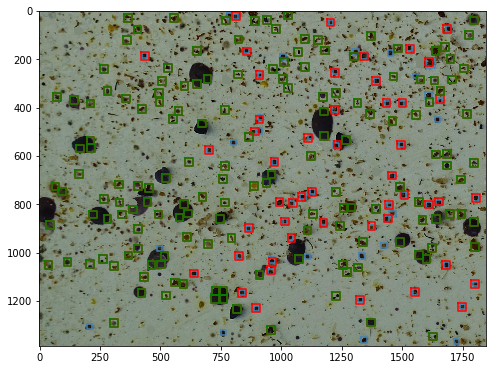

In [89]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.imshow(img_dict['train'][20])

for window in test_windows:
    
    plot_window(window)

for window in filtered_windows:
    plot_window(window, c = 'red')
    
for window in windows:
    
    plot_window(window, c = 'green')

## 3.2 Yolo implementation

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [57]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [60]:
for item in pred_dict.items():
    
    print(len(item[1]))

147
0
166
13
28
4
60
0
1
248
28
117
42
7
0
13
36
24
8
5
69
185
8
18
150
117
75
5
2
12
424
0
27
27
1
13
101
51
22
35
0
29
9
387
31
30
139
99
18
74
30
0
35
15
22
13
1
3
711
15
36
34
68
4
3
44
2
46
5
24
86
313
1
12
12
17
17
2
4
4
5
239
23
90
19
83
45
32
112
27
13
38
62
516
3
14
0
24
44
35
39
149
38
59
3
232
4
94
123
6
365
33
0
0
338
0
70
0
120
0
8
1
96
58
2
50
36
42
147
88
44
79
41
64
1
75
41
1
229
0
19
0
19
27
0
279
131
13
5
24
49
174
0
57
114
5
23
7
5
124
0
5
135
0
117
3
26
7
119
1
7
1
134
16
68
76
97
25
102
16
299
123
3
30
63
39
35
7
38
3
7
51
10
4
0
9
120
2
16
10
10
4
9
11
29
29
8
124
33
0
2
5
54
14
12
31
0
6
18
0
0
31
1
108
2
0
10
11
13
0
2
394
1
23
55
123
14
0
12
39
90
95
6
9
26
47
13
97
1
43
0
5
227
16
12
0
40
0
78


In [41]:
# Get challenge imgs
filenames = os.listdir('./competition')
challenge_imgs = skimage.io.imread_collection([f'./competition/{img_name}'
                                                      for img_name in filenames])
    

In [47]:
filenames[0][: len(filenames[0]) - 4]

'59f0a549a07d563535ffc6d6_32.00px_18'

In [56]:
pred_dict = dict()

for i, filename in enumerate(filenames):
    
    print(f'Processing {i}th img')
    
    # Get prefix
    prefix = filename[: len(filename) - 4]
    
    # Get img
    img = skimage.io.imread(f'./competition/{filename}')
    
    # Predict windows
    windows = detect_by_svc(img)
    
    # Store (prefix, windows) pair
    pred_dict[prefix] = windows


Processing 0th img
Processing 1th img
Processing 2th img
Processing 3th img
Processing 4th img
Processing 5th img
Processing 6th img
Processing 7th img
Processing 8th img
Processing 9th img
Processing 10th img
Processing 11th img
Processing 12th img
Processing 13th img
Processing 14th img
Processing 15th img
Processing 16th img
Processing 17th img
Processing 18th img
Processing 19th img
Processing 20th img
Processing 21th img
Processing 22th img
Processing 23th img
Processing 24th img
Processing 25th img
Processing 26th img
Processing 27th img
Processing 28th img
Processing 29th img
Processing 30th img
Processing 31th img
Processing 32th img
Processing 33th img
Processing 34th img
Processing 35th img
Processing 36th img
Processing 37th img
Processing 38th img
Processing 39th img
Processing 40th img
Processing 41th img
Processing 42th img
Processing 43th img
Processing 44th img
Processing 45th img
Processing 46th img
Processing 47th img
Processing 48th img
Processing 49th img
Processing

In [58]:
generate_pred_json(pred_dict)

59f0a549a07d563535ffc6d6_32.00px_18
5a0340b2a07d56baef59b1a2_32.00px_1
5a08c1dca07d56baef59b1d7_32.00px_3
5a08c1dca07d56baef59b1d7_32.00px_4
59ee03c2a07d563535ffc6c4_32.00px_2
5a062606a07d56baef59b1d3_32.00px_7
5a062606a07d56baef59b1d3_32.00px_8
5902310d579e52581ddede9e_32.00px_4
59f0a549a07d563535ffc6d6_32.00px_3
5a3431e0a07d567f57e0272c_32.00px_5
5b18d93da07d5605be933de1_32.00px_11
5a19ca0ba07d5643ecfab278_32.00px_0
598a0f0f579e528819ade1f0_32.00px_1
5a1e4ac3a07d5643ecfab295_32.00px_1
5902310d579e52581ddede9e_32.00px_11
5a1e4ac3a07d5643ecfab295_32.00px_0
59a70420a07d566c40c75c44_32.00px_0
599ab164579e52a0e6c05e54_32.00px_0
59f0a549a07d563535ffc6d6_32.00px_2
59ee03c2a07d563535ffc6c4_32.00px_12
59a7e010a07d5673b460e518_32.00px_3
59496f73579e529fdea8af00_32.00px_6
59f0a549a07d563535ffc6d6_32.00px_0
59ee03c2a07d563535ffc6c4_32.00px_6
5a0340b2a07d56baef59b1a2_32.00px_16
5a02bb74a07d56e705f896a6_32.00px_10
59f0a549a07d563535ffc6d6_32.00px_12
5902310d579e52581ddede9e_32.00px_2
5902310d579e5

In [26]:
with open('/home/liangwei/work/ComputerScience/ComputerVision/keras-yolo2/data/input.txt', 'w+') as f:
    
    for i in range(800):
        
        f.write(f'../inputs/train/images/{i}.jpg\n')